In [1]:
import sys,os,signal
import os.path

from numpy import *
from stats.transform import stft,standardise
import musicnet

import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss

import matplotlib.pyplot as plt
from IPython.display import Audio
from gc import collect

from sklearn.metrics import average_precision_score
from sklearn.decomposition import PCA,FastICA
from matplotlib.pyplot import *
%matplotlib inline

In [20]:
import pickle

In [2]:
# os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
# os.environ['CUDA_VISIBLE_DEVICES']='3'

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers

batch_size = 100
kwargs = {'num_workers': 6, 'pin_memory': True, 'worker_init_fn': worker_init}
fs = 44100

m = 128
k = 500
d = 4096
window = 5*fs
stride = 512
regions = 1 + (window - d)/stride

In [26]:
with open('/datadrive/musicnet/train/labels/2282.pckl') as file:
    tree = pickle.load(file)

In [27]:
tree

IntervalTree([Interval(177630, 239069, (7, 47, 0.0, 0.489583333333, 'Eighth')), Interval(177630, 400350, (7, 74, 0.0, 3.48958333333, 'Dotted Half')), Interval(177630, 400350, (7, 78, 0.0, 3.48958333333, 'Dotted Half')), Interval(239582, 268254, (7, 50, 0.5, 0.489583333333, 'Eighth')), Interval(268766, 292318, (7, 54, 1.0, 0.489583333333, 'Eighth')), Interval(292830, 314334, (7, 59, 1.5, 0.489583333333, 'Eighth')), Interval(314846, 338398, (7, 58, 2.0, 0.489583333333, 'Eighth')), Interval(338910, 353246, (7, 59, 2.5, 0.489583333333, 'Eighth')), Interval(353246, 435166, (7, 47, 3.0, 0.989583333333, 'Quarter')), Interval(400350, 435166, (7, 76, 3.5, 0.489583333333, 'Eighth')), Interval(400350, 435166, (7, 79, 3.5, 0.489583333333, 'Eighth')), Interval(435166, 459230, (7, 76, 4.0, 0.489583333333, 'Eighth')), Interval(435166, 459230, (7, 79, 4.0, 0.489583333333, 'Eighth')), Interval(459230, 484829, (7, 74, 4.5, 0.489583333333, 'Eighth')), Interval(459230, 484829, (7, 78, 4.5, 0.489583333333,

In [3]:
with musicnet.MusicNet() as data:
    audio,label = data[1]

    time = linspace(0,data.window,audio.size)/data.sample_frequency
    t,f,s = stft(audio,time)
    
    figure(figsize=(10,10))
    
    for inst in xrange(11):
        inst_mask = amax(label[:,:,inst],axis=1).todense().astype(bool)
        plot(time, audio/amax(audio),'k',alpha=0.01) 
        plot(time[inst_mask], audio[inst_mask]/amax(audio),'.',alpha=0.01)
    
    xlabel(r'Time, $t$ / s',fontsize=16)
    ylabel(r'Instrument, $\bar{\mathrm{y}}(t)$',fontsize=16)
    ylim(-1,1)
    
Audio(audio,rate=44100)

IOError: [Errno 2] No such file or directory: '/datadrive/musicnet/test/labels/2298.npz'

NameError: name 'n' is not defined

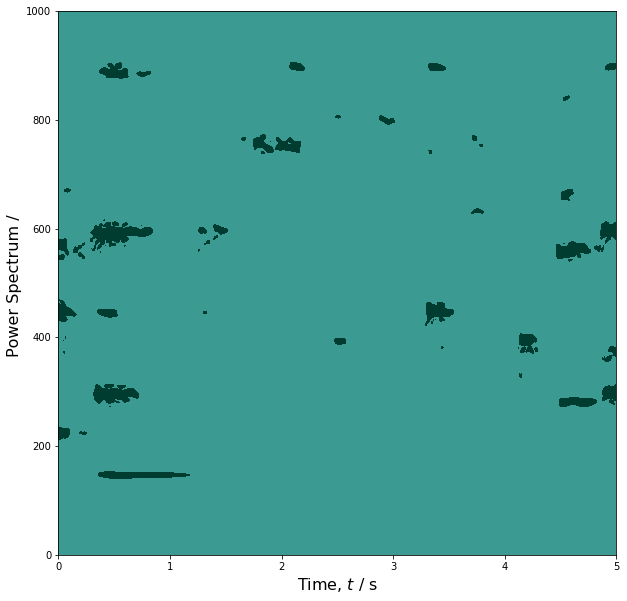

In [29]:
collect()
figure(figsize=(10,10))

t,f,s = stft(audio,time,window=0.1)
S = abs(s)

contourf(t,f,S,cmap='BrBG',vmin=mean(S)-2*std(S),vmax=mean(S)+2*std(S))
xlabel(r'Time, $t$ / s',fontsize=16)
ylabel(r'Power Spectrum / ',fontsize=16);

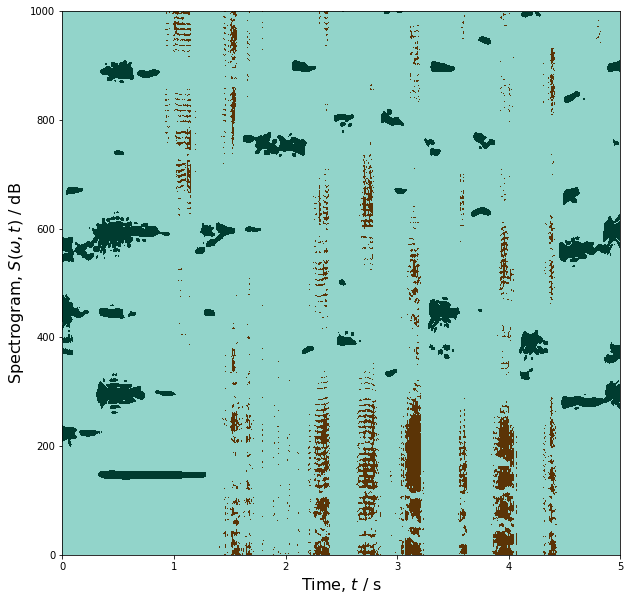

In [31]:
S = log10(abs(s))
collect()

figure(figsize=(10,10))
contourf(t,f,S,cmap='BrBG',vmin=mean(S)-2*std(S),vmax=mean(S)+2*std(S))
xlabel(r'Time, $t$ / s',fontsize=16)
ylabel(r'Spectrogram, $S(\omega,t)$ / $\mathrm{dB}$',fontsize=16);

In [41]:
.shape

(220500, 500)

In [55]:
pca = FastICA(n_components=2, whiten=False)
pca1,pca2 = pca.fit_transform(S.T).T

/usr/local/lib/python2.7/dist-packages/sklearn/decomposition/fastica_.py:295: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn('Ignoring n_components with whiten=False.')


MemoryError: 

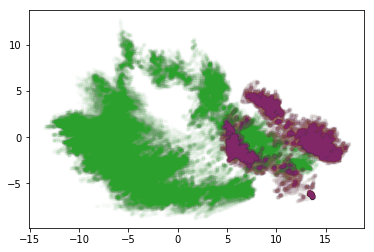

In [53]:
for inst in xrange(11):
    
    inst_mask = amax(label[:,:,inst],axis=1).todense().astype(bool)
    plot(pca1[inst_mask], pca2[inst_mask],'.',alpha=0.01)

In [55]:
x = lil_matrix((1000000,11),dtype=uint8)
z = x.tocsr()

In [56]:
%timeit z[1000:2000]
z[1000:2000]

10000 loops, best of 3: 160 µs per loop


<1000x11 sparse matrix of type '<type 'numpy.uint8'>'
	with 0 stored elements in Compressed Sparse Column format>

In [29]:
z = x.tocsr()

In [21]:
for item in listdir('/datadrive/musicnet/test/labels'):
    if not item.endswith('.csv'): continue
    uid = int(item[:-4])
    tree = IntervalTree()
    with open(join('/datadrive/musicnet/test/labels',item), 'rb') as f:
        reader = csv.DictReader(f, delimiter=',')
        for label in reader:
            start_time = int(label['start_time'])
            end_time = int(label['end_time'])
            instrument = int(label['instrument'])
            note = int(label['note'])
            start_beat = float(label['start_beat'])
            end_beat = float(label['end_beat'])
            note_value = label['note_value']
            tree[start_time:end_time] = (instrument,note,start_beat,end_beat,note_value)
            
    with open(join('/datadrive/musicnet/test/labels',str(uid)+'.pckl'), 'wb') as f:
        pickle.dump(tree, f)
        
    print uid

2628
1819
2416
2106
1759
2382
2298
2556
2191
2303


In [19]:
import pickle

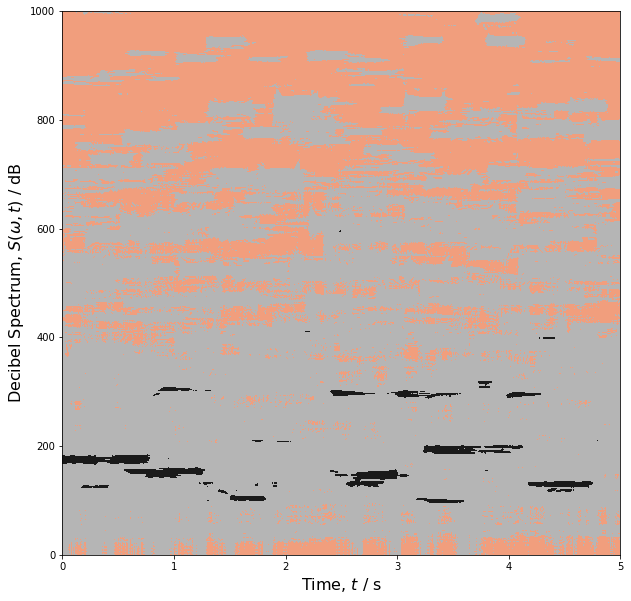

In [7]:
S = standardise(log10(abs(s)),axis=0)
collect()

figure(figsize=(10,10))
contourf(t,f,S,cmap='RdGy',vmin=-3,vmax=3)
xlabel(r'Time, $t$ / s',fontsize=16)
ylabel(r'Decibel Spectrum, $S(\omega,t)$ / $\mathrm{dB}$',fontsize=16);

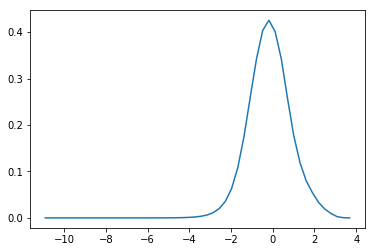

In [61]:
plot(bins[:-1],hist)

In [62]:
std(S)

0.9999997683007182

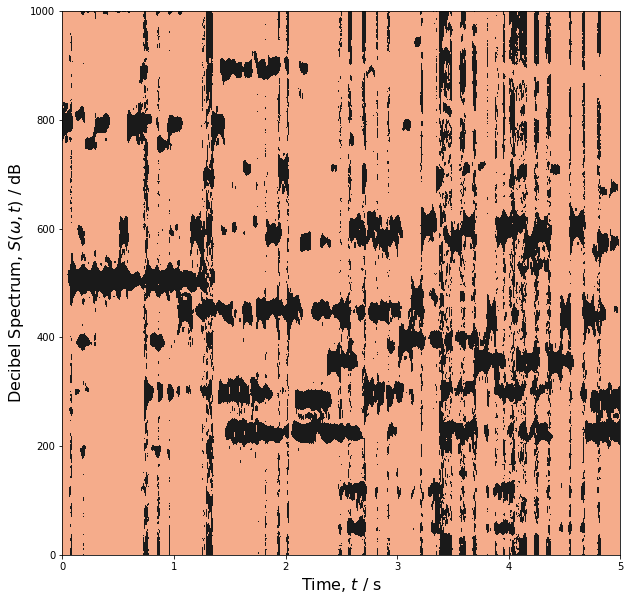

In [44]:
S = log10(abs(standardise(abs(s),axis=0)))
collect()

figure(figsize=(10,10))
contourf(t,f,S,cmap='RdGy',vmin=mean(S)-2*std(S),vmax=mean(S)+2*std(S))
xlabel(r'Time, $t$ / s',fontsize=16)
ylabel(r'Decibel Spectrum, $S(\omega,t)$ / $\mathrm{dB}$',fontsize=16);

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

In [ ]:
def create_filters(d,k,low=50,high=6000):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    num_cycles = start_freq*d/44000.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[ind,0,:] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[ind,0,:] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
    
    return wsin,wcos

In [ ]:
wsin,wcos = create_filters(d,k)

with torch.cuda.device(0):
    wsin_var = Variable(torch.from_numpy(wsin).cuda(), requires_grad=False)
    wcos_var = Variable(torch.from_numpy(wcos).cuda(), requires_grad=False)
    
def init_weights(scale=0.):
    wscale = 0.
    with torch.cuda.device(0):
        beta = Variable(wscale*torch.rand(regions*k,m).cuda(), requires_grad=True)
        betaavg = Variable(beta.data.clone(), requires_grad=False)
    return (beta,), (betaavg,)

def forward(x, beta):
    zx = conv1d(x[:,None,:], wsin_var, stride=stride).pow(2) \
       + conv1d(x[:,None,:], wcos_var, stride=stride).pow(2)
    return torch.mm(torch.log(zx + musicnet.epsilon).view(x.data.size()[0],regions*k), beta)

def L(y_hat, y, beta):
    # adjust for per-frame loss
    return mse_loss(y_hat, y)*128/2.# + .01*torch.mean(beta.pow(2.))

# Train the model

In [ ]:
weights, averages = init_weights()
loss_history = []
avgp_history = []

In [ ]:
avg = .9998
optimizer = torch.optim.SGD(weights, lr=0.000001, momentum=.95)

try:
    with train_set, test_set:
        print 'square loss\tavg prec\ttime\t\tutime'
        for epoch in xrange(50):
            t = time()
            for i, (x, y) in enumerate(train_loader):
                optimizer.zero_grad()
                x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                loss = L(forward(x,*weights),y,*weights)
                loss.backward()
                optimizer.step()

                for w,wavg in zip(weights, averages):
                    wavg.copy_(avg*wavg + (1.-avg)*w)

            t1 = time()
            avgp, loss = 0., 0.
            yground = torch.FloatTensor(batch_size*len(test_loader), m)
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            for i, (x, y) in enumerate(test_loader):
                x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                yhatvar = forward(x,*averages)
                loss += L(yhatvar,y,*averages).data[0]
                yground[i*batch_size:(i+1)*batch_size,:] = y.data
                yhat[i*batch_size:(i+1)*batch_size,:] = yhatvar.data
            avgp = average_precision_score(yground.numpy().flatten(),yhat.numpy().flatten())
            loss_history.append(loss/len(test_loader))
            avgp_history.append(avgp)
            print '{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(loss_history[-1],avgp_history[-1],time()-t, time()-t1)

except KeyboardInterrupt:
    print 'Graceful Exit'
else:
    print 'Finished'

In [ ]:
burnin = 1

fig = plt.figure(figsize=(15, 7))
fig.add_axes()

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.tick_params(direction='out', color='b', width='2')
    
ax1.set_title('square loss')
ax1.plot(np.arange(len(loss_history[burnin:])), loss_history[burnin:])
ax2.set_title('average precision')
ax2.plot(np.arange(len(avgp_history[burnin:])), avgp_history[burnin:])